In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7
Gs['q'] = 0.015

# Signal parameters
K = 3
n_signals = 50
n_p = 0.1

# Model parameters
epochs = 500
lr = 0.001

# Create graph
G = ds.create_graph(Gs, SEED)
A = G.W.todense()
Lambda_A, _ = utils.ordered_eig(A)
print('lambda max of A:', Lambda_A[0])
plt.figure()
plt.imshow(A)


# Create filter H and decoder
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
H = x_dw.H
Lambda_H, _ = utils.ordered_eig(H)
print('lambda max of H:', Lambda_H[0])

# Prepare experiments
exps = []
fts = [48, 150, 640]
params = [1, 2, 4, 8, 16, 32, 64]

lambda max of A: 11.375529656810523
Filter coefs: [0.29399155 0.38311672 0.32289173]
lambda max of H: 46.435200314575944


In [2]:
# Fit models
err1 = np.zeros((len(fts), len(params), n_signals, epochs, G.N))
err_wrt_n1 = np.zeros((len(fts), len(params), n_signals, epochs, G.N))
start_time = time.time()
for i in range(n_signals):
    for j, ft in enumerate(fts):
        dec = GraphDecoder(ft, H)
        JJ = dec.analytical_squared_jacobian()
        Lambda, V = utils.ordered_eig(JJ)
        for k, p in enumerate(params):
            x = ds.bandlimited_signal(Lambda, V, p)
            x_n = ds.GraphSignal.add_noise(x, n_p)
            model = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
            err_wrt_n1[j, k, i, :, :], err1[j, k, i, :, :], _ = model.fit(x_n, x, reduce_err=False)

    print(i, end = ' ')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 --- 9.647646967569987 minutes ---


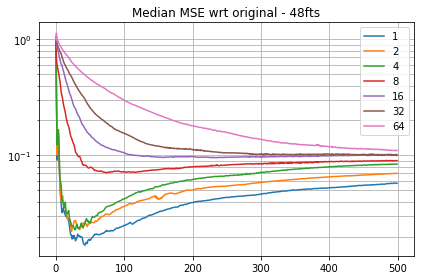

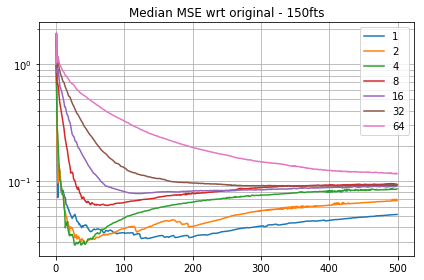

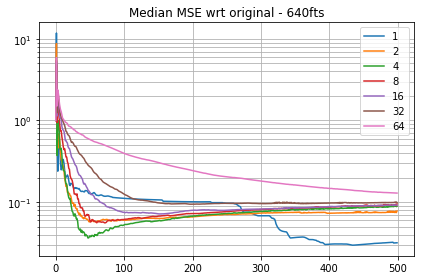

In [8]:
# Plots Median Error
for i, ft in enumerate(fts):
    med_mse = np.median(np.sum(err1[i, :], axis=3), axis=1)
    plt.figure()
    plt.semilogy(med_mse.T)
    plt.grid(True, which='both')
    plt.legend(params)
    plt.title('Median MSE wrt original - {}fts'.format(ft))
    plt.tight_layout()

    #med_mse_n = np.median(np.sum(err_wrt_n1[i, :], axis=3), axis=1)
    #plt.figure()
    #plt.semilogy(med_mse_n.T)
    #plt.grid(True, which='both')
    #plt.legend(params)
    #plt.title('Median MSE wrt noise - {}fts'.format(ft))
    #plt.tight_layout()

## Normalizing H

In [4]:
H = x_dw.H/np.linalg.norm(x_dw.H)

# Fit models
err2 = np.zeros((len(fts), len(params), n_signals, epochs, G.N))
err_wrt_n2 = np.zeros((len(fts), len(params), n_signals, epochs, G.N))
start_time = time.time()
for i in range(n_signals):
    for j, ft in enumerate(fts):
        dec = GraphDecoder(ft, H, )
        JJ = dec.analytical_squared_jacobian()
        Lambda, V = utils.ordered_eig(JJ)
        for k, p in enumerate(params):
            x = ds.bandlimited_signal(Lambda, V, p)
            x_n = ds.GraphSignal.add_noise(x, n_p)
            model = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
            err_wrt_n2[j, k, i, :, :], err2[j, k, i, :, :], _ = model.fit(x_n, x, reduce_err=False)

    print(i, end = ' ')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 --- 7.8686558922131855 minutes ---


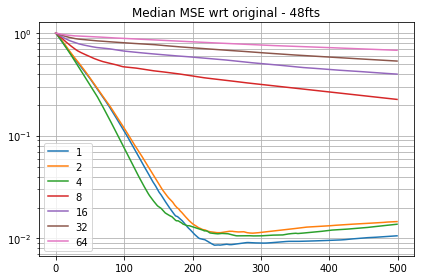

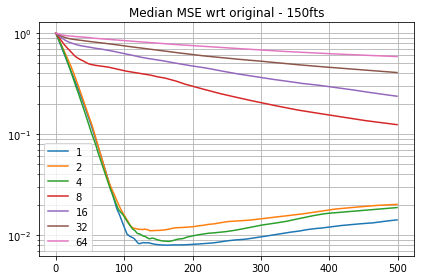

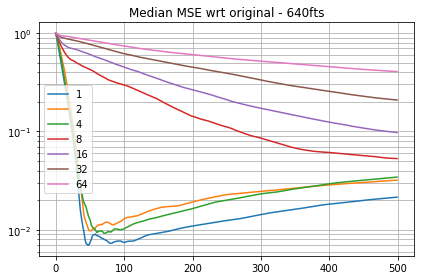

In [5]:
# Plots Median Error
for i, ft in enumerate(fts):
    med_mse = np.median(np.sum(err2[i, :], axis=3), axis=1)
    plt.figure()
    plt.semilogy(med_mse.T)
    plt.grid(True, which='both')
    plt.legend(params)
    plt.title('Median MSE wrt original - {}fts'.format(ft))
    plt.tight_layout()

    #med_mse_n = np.median(np.sum(err_wrt_n[i, :], axis=3), axis=1)
    #plt.figure()
    #plt.semilogy(med_mse_n.T)
    #plt.grid(True, which='both')
    #plt.legend(params)
    #plt.title('Median MSE wrt noise - {}fts'.format(ft))
    #plt.tight_layout()

In [6]:
plt.show()